### Functions

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# The address of the folder where the images are located
path = "Chest"
image_list = os.listdir(path)
loaded_image = []
image_size = 1000

# Create the "Mask" directory if it doesn't exist
current_dir = os.getcwd()
output_dir = os.path.join(current_dir, "Mask")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Display images
def display_image(image, txt):
    plt.imshow(image, 'gray')
    plt.title(txt, color='black', fontsize=14)
    plt.axis('off')
    plt.show()
    
# Separator of white and black lungs    
def black_white (image):
    # Because the color of the lungs is not the same in different images, I divided the lungs into two groups: white lungs and black lungs.
    # To determine whether the lung is black or white, I selected a square (10x10) from the part of the images that is definitely inside 
    # the lung and averaged the color value of the pixels inside the square.
    rectangle = image[30:40, 30:40]
    mean_pixel = np.mean(rectangle)
    
    # black lungs
    if mean_pixel < 100:
        # Manually threshold
        image = np.where(image > 140, 255, image)
        image = np.where(image < 140, 0, image)  
        # Binary inverse to whiten the color of the lungs
        ret, image = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)
    
    # white lungs
    else :
        # Manually threshold
        image = np.where(image > 80, 255, image)
        image = np.where(image < 100, 0, image) 
    
    return image

# Blacken pixels from left and right side    
def Placing_black_pixels (image,side):       
    width, height = image.shape[:2]
    pixel_num = 5
    # from right side
    if side == 'right':    
        for h in range(height - 1):
            for w in reversed(range(1, width)):  
                is_white = False
                for i in range(1, pixel_num):    # Check the next 5 pixels
                    if w - i < 0:
                        break
                    if image[h, w - i] == 255:
                        is_white = True
                        break
                if is_white:
                    image[h, w] = 0
                else:
                    image[h, w] = 0
                    break
    # from left side
    if side == 'left':    
        for h in range(height - 1):
            for w in range(width - 1):
                is_white = False
                for i in range(1, pixel_num ):  # Check the next 5 pixels
                    if w + i >= width:
                        break
                    if image[h, w + i] == 255:
                        is_white = True
                        break
                if is_white:
                    image[h, w] = 0
                else:
                    image[h, w] = 0
                    break
    return image

def Extraction_of_large_contours (image):
    # Find contours
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Sort the contours based on area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # Select the top five largest contours
    top_contours = contours[:2]
    # Create a black image
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # Draw the selected contours on the black image
    cv2.drawContours(image, top_contours, -1, 255, thickness=cv2.FILLED)
    
    return image

### Stage display

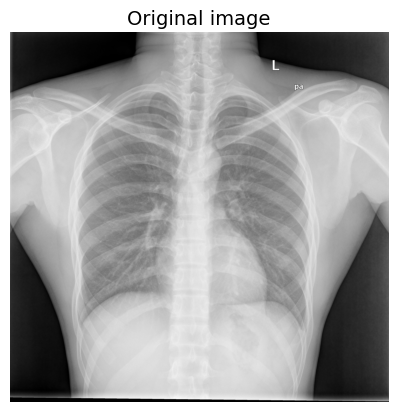

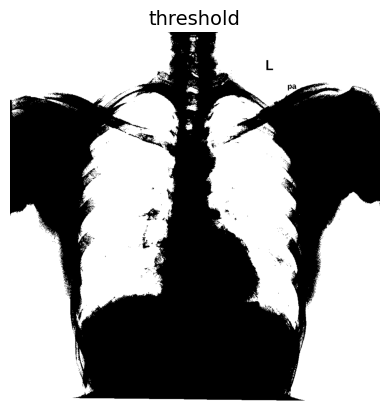

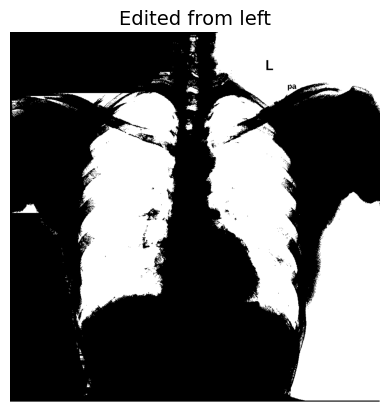

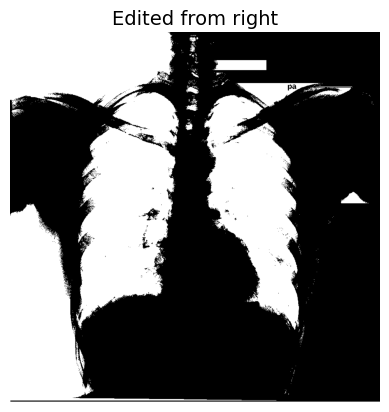

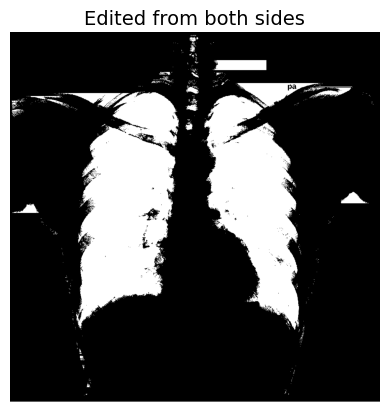

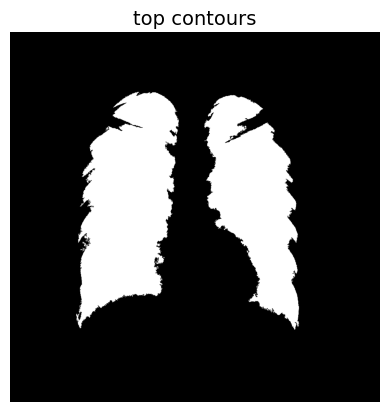

In [2]:
for image_name in image_list:                            # Select image from folder  
    # opening
    image = Image.open(os.path.join(path, image_name))
    display_image(image, 'Original image')  
    
    # resizing
    image = image.resize((image_size, image_size)) 
       
    # Convert to numpy array
    image = np.array(image)  
    
    # black amd white lung threshold
    image = black_white(image)
    display_image(image, 'threshold')
    
    # Blacken pixels from left and right    
    edited_image_left = Placing_black_pixels(image.copy(), 'left')
    display_image(edited_image_left, 'Edited from left')
    edited_image_right = Placing_black_pixels(image.copy(), 'right')
    display_image(edited_image_right, 'Edited from right')
    image = Placing_black_pixels(image.copy(), 'left') ; image = Placing_black_pixels(image, 'right')
    display_image(image, 'Edited from both sides')
    
    # Extraction of large contours
    image = Extraction_of_large_contours(image)
    display_image(image, 'top contours')